**Binary Classification with a Deepl Learning Model**

In [1]:
# packages
import os
import numpy as np
import pandas as pd

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, InputLayer

from sklearn.metrics import classification_report, confusion_matrix, precision_score, f1_score
from sklearn.model_selection import TimeSeriesSplit, KFold
from matplotlib import pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

from keras.models import Model
from keras.layers import Input, Conv1D, BatchNormalization, ReLU, GlobalAveragePooling1D, Dense
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.utils import to_categorical


In [2]:
# mount your google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Load lagged data

In [4]:
df_lagged = pd.read_csv('/content/drive/My Drive/ms_wind_curtailment_prediction/lagged_curtailment_target_features.csv', sep = ';', index_col=0)

In [9]:
# setting index to datetime
df_lagged.index = pd.to_datetime(df_lagged.index)

Dropping wind speed


In [ ]:
'''
df.drop(['wind_speed_m/s', 'actual_solar_MW'], inplace=True, axis=1)
'''

Adding weekday and season cols

In [10]:
'''
# Assuming df_lagged is your DataFrame with a datetime index
# Create a new column for weekday/weekend
df_lagged['weekday'] = df_lagged.index.weekday < 5

# Create a new column for season based on month
df_lagged['season'] = (df_lagged.index.month % 12 + 3) // 3

# Perform one-hot encoding for the 'season' column
df_lagged = pd.get_dummies(df_lagged, columns=['season'], drop_first=True)

# Perform one-hot encoding for the 'weekday' column
df_lagged = pd.get_dummies(df_lagged, columns=['weekday'], drop_first=True)

# Convert the 'weekday' and 'season' columns to numerical
df_lagged['weekday'] = df_lagged['weekday_True'].astype(int)
df_lagged['season'] = df_lagged[['season_2', 'season_3', 'season_4']].idxmax(axis=1).str.extract(r'(\d)').astype(int)

# Drop the intermediate columns created during one-hot encoding
df_lagged.drop(columns=['weekday_True', 'season_2', 'season_3', 'season_4'], inplace=True)

# Now df_lagged contains the original data with the new weekday and season columns encoded numerically
'''

Deep learning model with 3 hidden layers consisting of 100, 50 and 25 neurons

In [23]:
# get desired df size
start_date = '2022-01-01' #'2021-01-01'
end_date = '2022-12-31' #'2023-06-30'
df_filtered = df_lagged.loc[start_date:end_date]

In [24]:
# impute, scale pipeline and smote (for class imbalance)
preprocessor = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('scaler', StandardScaler())
])

smote = SMOTE(random_state=13)

# define features X and target y
X = df_filtered.drop(['redispatch', 'level'], axis = 1)
y = df_filtered['redispatch']

In [32]:
# Define model architecture
def make_model(input_shape, num_classes):
    model = Sequential([
        InputLayer(input_shape),
        Dense(100, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)), # add l2 regularization
        tf.keras.layers.Dropout(0.5), #add dropout layers to reduce overfitting
        Dense(50, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)), # add l2 regularization
        tf.keras.layers.Dropout(0.5),
        Dense(25, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    return model

# Model parameters
input_shape = X.shape[1:] # X_train_balanced.shape[1:]
num_classes = 1  # Binary classification

# Define callbacks
callbacks = [
    ModelCheckpoint("best_model.keras", save_best_only=True, monitor="val_loss"),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001),
    EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]

In [ ]:
# cross-validation
n_splits = 5
test_size = 48 #(48 - 12h with 15 min intervalls)
tscv = TimeSeriesSplit(n_splits=n_splits, test_size=test_size, gap = 10)

# Initialize lists to store evaluation metrics for each fold
f1_scores_train = []
precision_scores_train = []
f1_scores_test = []
precision_scores_test = []

# Iterate over each fold
for fold, (train_index, test_index) in enumerate(tscv.split(X), 1):
    print(f"Training on fold {fold}/{n_splits}")

    # Get the data for this fold
    X_train_fold, X_val_fold = X.iloc[train_index], X.iloc[test_index]
    y_train_fold, y_val_fold = y.iloc[train_index], y.iloc[test_index]

    # preprocess train data
    X_train_balanced = preprocessor.fit_transform(X_train_fold)
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train_balanced, y_train_fold)

    # Create model instance
    model = make_model(input_shape, num_classes)

    # Compile the model
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy", tf.keras.metrics.Precision()])

    # to address the class imbalance further
    class_weights = {0: 1, 1: 2}
    # Train the model
    model.fit(
        X_train_fold, y_train_fold,
        validation_data=(X_val_fold, y_val_fold),
        epochs=22,  # 50
        batch_size=50,
        class_weight=class_weights,
        callbacks=callbacks,
        verbose=1
    )

    # preprocess validation/test data
    X_val_fold = preprocessor.transform(X_val_fold)

    # Predict on the validation/test set
    y_pred_val = model.predict(X_val_fold)
    y_pred_val_classes = (y_pred_val > 0.5).astype(int)
    f1_val = f1_score(y_val_fold, y_pred_val_classes)
    precision_val = precision_score(y_val_fold, y_pred_val_classes)
    f1_scores_test.append(f1_val)
    precision_scores_test.append(precision_val)

    # Predict on the train set
    y_pred_train = model.predict(X_train_fold)
    y_pred_train_classes = (y_pred_train > 0.5).astype(int)
    f1_train = f1_score(y_train_fold, y_pred_train_classes)
    precision_train = precision_score(y_train_fold, y_pred_train_classes)
    f1_scores_train.append(f1_train)
    precision_scores_train.append(precision_train)

    # Print evaluation metrics for fold
    print(f"Fold {fold} - Validation/Test F1 score: {f1_val}, Validation Precision: {precision_val}")
    print(f"Fold {fold} - Train F1 score: {f1_train}, Test Precision: {precision_train}")

# Print average scores across all folds
print("Average F1 score (Val):", np.mean(f1_scores_test))
print("Average Precision score (Val):", np.mean(precision_scores_test))
print("Average F1 score (Train):", np.mean(f1_scores_train))
print("Average Precision score (Train):", np.mean(precision_scores_train))


Training on fold 1/5
Epoch 1/22
696/696 [==============================] - 5s 4ms/step - loss: 1117.8956 - accuracy: 0.6543 - precision_7: 0.1652 - val_loss: 1.3129 - val_accuracy: 1.0000 - val_precision_7: 0.0000e+00 - lr: 0.0010
Epoch 2/22
696/696 [==============================] - 2s 4ms/step - loss: 20.3579 - accuracy: 0.7976 - precision_7: 0.1922 - val_loss: 1.2184 - val_accuracy: 1.0000 - val_precision_7: 0.0000e+00 - lr: 0.0010
Epoch 3/22
696/696 [==============================] - 2s 4ms/step - loss: 6.1127 - accuracy: 0.8252 - precision_7: 0.1737 - val_loss: 1.1799 - val_accuracy: 1.0000 - val_precision_7: 0.0000e+00 - lr: 0.0010
Epoch 4/22
696/696 [==============================] - 3s 4ms/step - loss: 2.9151 - accuracy: 0.8316 - precision_7: 0.1467 - val_loss: 1.1225 - val_accuracy: 1.0000 - val_precision_7: 0.0000e+00 - lr: 0.0010
Epoch 5/22
696/696 [==============================] - 2s 4ms/step - loss: 2.4159 - accuracy: 0.8342 - precision_7: 0.1789 - val_loss: 1.0863 - val_

Saving the deep learning model

In [ ]:
# Save deep learning model
deep_learning_model.save('deep_learning_model.h5')

Trying a convolutional neural network for classification

In [ ]:
start_date = pd.Timestamp('2020-01-01')
end_date = pd.Timestamp('2021-12-31 23:45:00')

# Filter rows that are outside of the specified timeframe
df_filtered = df_lagged[(df_lagged.index > end_date)]

df_filtered.head()

,redispatch,wind_direction_degrees,wind_direction_degrees_lag1,wind_direction_degrees_lag2,wind_direction_degrees_lag3,radiation_global_J/m2,radiation_global_J/m2_lag1,radiation_global_J/m2_lag2,radiation_global_J/m2_lag3,air_temperature_K,...,residual_load_MWh,residual_load_MWh_lag1,residual_load_MWh_lag2,residual_load_MWh_lag3,pumped_storage_MWh,pumped_storage_MWh_lag1,pumped_storage_MWh_lag2,pumped_storage_MWh_lag3,weekday,season
timestamp,,,,,,,,,,,,,,,,,,,,,
2022-01-01 00:00:00,0.0,270.0,270.0,270.0,270.0,0.0,0.0,0.0,0.0,282.05,...,212.98,215.08,223.97,230.88,39.98,50.40,46.20,47.45,0,2
2022-01-01 00:15:00,0.0,265.0,270.0,270.0,270.0,0.0,0.0,0.0,0.0,282.10,...,209.07,212.98,215.08,223.97,39.67,39.98,50.40,46.20,0,2
2022-01-01 00:30:00,0.0,270.0,265.0,270.0,270.0,0.0,0.0,0.0,0.0,282.35,...,208.60,209.07,212.98,215.08,43.30,39.67,39.98,50.40,0,2
2022-01-01 00:45:00,0.0,270.0,270.0,265.0,270.0,0.0,0.0,0.0,0.0,282.55,...,199.50,208.60,209.07,212.98,46.33,43.30,39.67,39.98,0,2
2022-01-01 01:00:00,0.0,270.0,270.0,270.0,265.0,0.0,0.0,0.0,0.0,282.65,...,194.30,199.50,208.60,209.07,39.12,46.33,43.30,39.67,0,2


In [ ]:
# Determine the cutoff point for splitting the data into train and test sets based on time
train_time = '2021-12-31'  # Define your train time
test_time_start = '2022-12-01'
test_time_end = '2023-01-01'

# Split the data into train and test sets based on time
train = df_filtered[(df_filtered.index > train_time) & (df_filtered.index < test_time_start)]
test = df_filtered[(df_filtered.index >= test_time_start) & (df_filtered.index < test_time_end)]

# Prepare the data
X_train = train.drop(columns=['redispatch'])  # Extract features
y_train = train['redispatch']  # Extract target

X_test = test.drop(columns=['redispatch'])  # Extract features
y_test = test['redispatch']  # Extract target

In [ ]:
# Normalize or scale the features if necessary
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Balance the classes in the training data using SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

Using cross validation with CNN model

In [ ]:
# Reshape the input data to have a 3D shape
X_train_balanced_reshaped = np.expand_dims(X_train_balanced, axis=-1)
X_test_scaled_reshaped = np.expand_dims(X_test_scaled, axis=-1)

# Define the number of splits for time series cross-validation
n_splits = 5

# Define the TimeSeriesSplit cross-validation strategy
tscv = TimeSeriesSplit(n_splits=n_splits)

# Define model architecture
def make_model(input_shape, num_classes):
    input_layer = Input(input_shape)

    conv1 = Conv1D(filters=64, kernel_size=3, padding="same")(input_layer)
    conv1 = BatchNormalization()(conv1)
    conv1 = ReLU()(conv1)

    conv2 = Conv1D(filters=64, kernel_size=3, padding="same")(conv1)
    conv2 = BatchNormalization()(conv2)
    conv2 = ReLU()(conv2)

    conv3 = Conv1D(filters=64, kernel_size=3, padding="same")(conv2)
    conv3 = BatchNormalization()(conv3)
    conv3 = ReLU()(conv3)

    gap = GlobalAveragePooling1D()(conv3)

    output_layer = Dense(num_classes, activation="softmax")(gap)

    return Model(inputs=input_layer, outputs=output_layer)

# Model parameters
input_shape = X_train_balanced_reshaped.shape[1:]
num_classes = len(np.unique(y_train_balanced))

# Define callbacks
callbacks = [
    ModelCheckpoint("best_model.keras", save_best_only=True, monitor="val_loss"),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001),
    EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]

# Initialize lists to store evaluation metrics for each fold
f1_scores = []
precision_scores = []
train_f1_scores = []
train_precision_scores = []
test_f1_scores = []
test_precision_scores = []

# Iterate over each fold
for fold, (train_index, test_index) in enumerate(tscv.split(X_train_balanced_reshaped), 1):
    print(f"Training on fold {fold}/{n_splits}")

    # Get the data for this fold
    X_train_fold, X_val_fold = X_train_balanced_reshaped[train_index], X_train_balanced_reshaped[test_index]
    y_train_fold, y_val_fold = y_train_balanced[train_index], y_train_balanced[test_index]

    # Create model instance
    model = make_model(input_shape, num_classes)

    # Compile the model
    model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

    # Train the model
    history = model.fit(
        X_train_fold, y_train_fold,
        validation_data=(X_val_fold, y_val_fold),
        epochs=500,
        batch_size=32,
        callbacks=callbacks,
        verbose=1
    )

    # Predict on the validation set
    y_pred_val = model.predict(X_val_fold)
    y_pred_val_classes = np.argmax(y_pred_val, axis=1)

    # Calculate evaluation metrics for validation set
    f1 = f1_score(y_val_fold, y_pred_val_classes, average='macro')
    precision = precision_score(y_val_fold, y_pred_val_classes, average='macro')

    f1_scores.append(f1)
    precision_scores.append(precision)

    # Predict on the training set
    y_pred_train = model.predict(X_train_fold)
    y_pred_train_classes = np.argmax(y_pred_train, axis=1)

    # Calculate evaluation metrics for training set
    train_f1 = f1_score(y_train_fold, y_pred_train_classes, average='macro')
    train_precision = precision_score(y_train_fold, y_pred_train_classes, average='macro')

    train_f1_scores.append(train_f1)
    train_precision_scores.append(train_precision)

    # Predict on the test set
    y_pred_test = model.predict(X_test_scaled_reshaped)
    y_pred_test_classes = np.argmax(y_pred_test, axis=1)

    # Calculate evaluation metrics for test set
    test_f1 = f1_score(y_test, y_pred_test_classes, average='macro')
    test_precision = precision_score(y_test, y_pred_test_classes, average='macro')

    test_f1_scores.append(test_f1)
    test_precision_scores.append(test_precision)

# Print average scores across all folds
print("Average F1 score (validation):", np.mean(f1_scores))
print("Average precision score (validation):", np.mean(precision_scores))
print("Average F1 score (train):", np.mean(train_f1_scores))
print("Average precision score (train):", np.mean(train_precision_scores))
print("Average F1 score (test):", np.mean(test_f1_scores))
print("Average precision score (test):", np.mean(test_precision_scores))

Training on fold 1/5
Epoch 1/500
280/280 [==============================] - 6s 7ms/step - loss: 0.1080 - accuracy: 0.9729 - val_loss: 0.6433 - val_accuracy: 0.8777 - lr: 0.0010
Epoch 2/500
280/280 [==============================] - 2s 6ms/step - loss: 0.0575 - accuracy: 0.9860 - val_loss: 0.6115 - val_accuracy: 0.8777 - lr: 0.0010
Epoch 3/500
280/280 [==============================] - 2s 6ms/step - loss: 0.0508 - accuracy: 0.9860 - val_loss: 0.6887 - val_accuracy: 0.8777 - lr: 0.0010
Epoch 4/500
280/280 [==============================] - 2s 6ms/step - loss: 0.0469 - accuracy: 0.9862 - val_loss: 1.0179 - val_accuracy: 0.8777 - lr: 0.0010
Epoch 5/500
280/280 [==============================] - 2s 6ms/step - loss: 0.0416 - accuracy: 0.9865 - val_loss: 0.9479 - val_accuracy: 0.8777 - lr: 0.0010
Epoch 6/500
280/280 [==============================] - 2s 6ms/step - loss: 0.0383 - accuracy: 0.9873 - val_loss: 0.7310 - val_accuracy: 0.8773 - lr: 0.0010
Epoch 7/500
280/280 [======================

In [ ]:
#CNN result
#Average F1 score: 0.5076440234099121
#Average precision score: 0.6114438993430864

In [ ]:
# is it overfitting?
# Batchnormalization: method to make artificial NNs faster and more stable through re-centering and re-scaling layers inputs
# Dropout: regularisation technique for reducing overfitting in ANNs by preventing complex co-adaptations on training data. Performing model averaging


In [ ]:
'''
## safe
!mkdir -p saved_model
large_model.save('saved_model/my_large_model')

!zip -r saved_model.zip saved_model

# push to GitHub see [3]

## load
# unzip files
import zipfile
with zipfile.ZipFile(‘./saved_model.zip', 'r') as zip_ref:
    zip_ref.extractall('./')

# Load the saved model
with tf.device('/device:GPU:0'):
    new_large_model = tf.keras.models.load_model('saved_model/my_large_model')

# Check its architecture
new_large_model.summary()'''

"\n## safe \n!mkdir -p saved_model\nlarge_model.save('saved_model/my_large_model')\n\n!zip -r saved_model.zip saved_model\n\n# push to GitHub see [3]\n\n## load\n# unzip files \nimport zipfile\nwith zipfile.ZipFile(‘./saved_model.zip', 'r') as zip_ref:\n    zip_ref.extractall('./')\n\n# Load the saved model\nwith tf.device('/device:GPU:0'):\n    new_large_model = tf.keras.models.load_model('saved_model/my_large_model')\n\n# Check its architecture\nnew_large_model.summary()"

Daily mean median and variance of redispatch

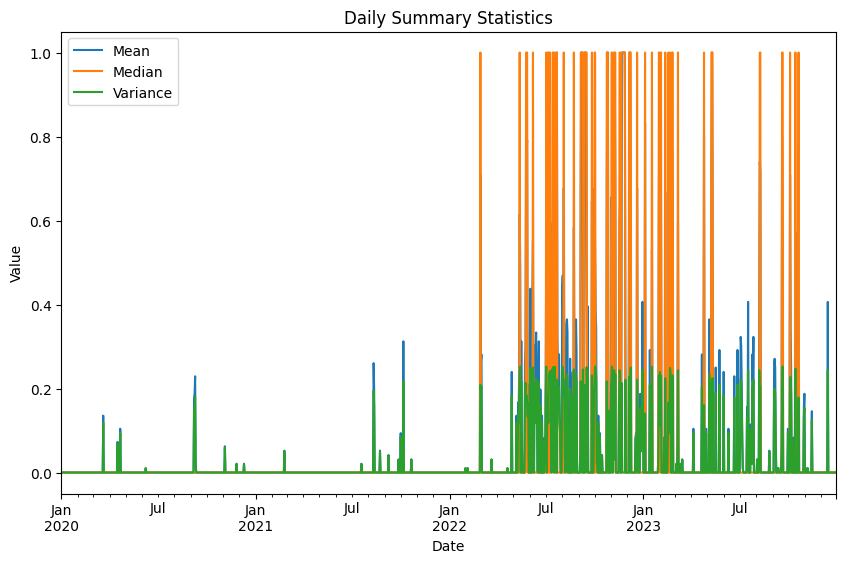

Autocorrelation: 0.960101247666363


In [ ]:
# Resample data to different time intervals (e.g., daily, weekly, monthly)
# Here, we calculate daily summary statistics
daily_summary = df['redispatch'].resample('D').agg(['mean', 'median', 'var'])

# Calculate autocorrelation
autocorr = df['redispatch'].autocorr()

# Plot summary statistics
daily_summary.plot(title='Daily Summary Statistics', figsize=(10, 6))
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend(['Mean', 'Median', 'Variance'])
plt.show()

print("Autocorrelation:", autocorr)

Weekly mean median and variance of redispatch

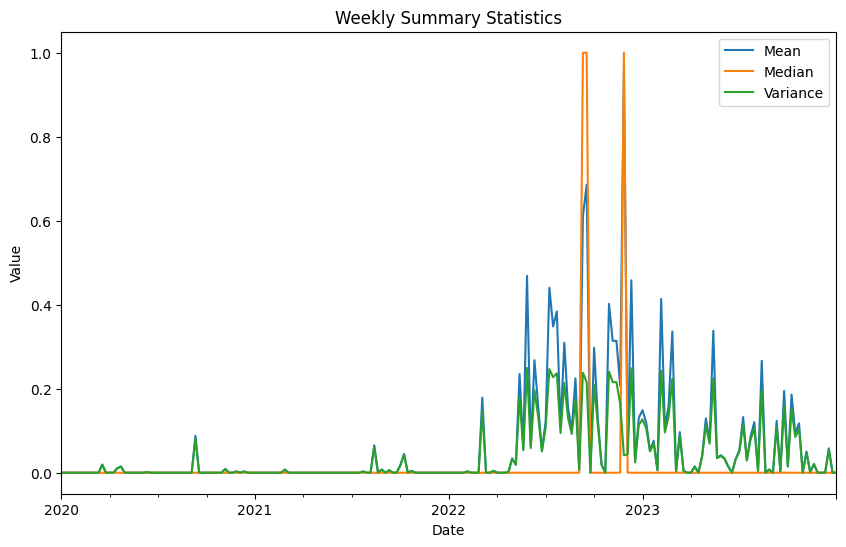

Autocorrelation: 0.960101247666363


In [ ]:
# Resample data to different time intervals (e.g., daily, weekly, monthly)
# Here, we calculate daily summary statistics
weekly_summary = df['redispatch'].resample('W').agg(['mean', 'median', 'var'])

# Calculate autocorrelation
autocorr = df['redispatch'].autocorr()

# Plot summary statistics
weekly_summary.plot(title='Weekly Summary Statistics', figsize=(10, 6))
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend(['Mean', 'Median', 'Variance'])
plt.show()

print("Autocorrelation:", autocorr)

Monthly mean median and variance of redispatch

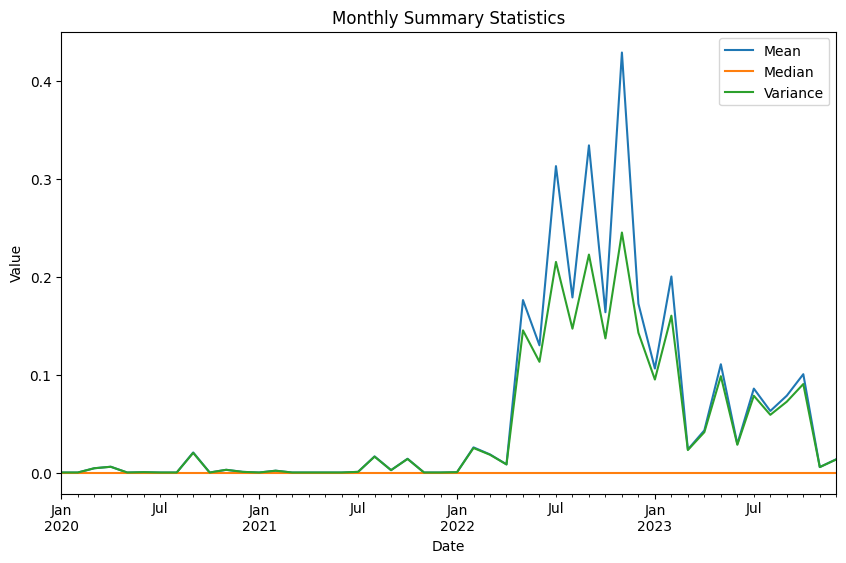

Autocorrelation: 0.960101247666363


In [ ]:
# Resample data to different time intervals (e.g., daily, weekly, monthly)
# Here, we calculate daily summary statistics
monthly_summary = df['redispatch'].resample('M').agg(['mean', 'median', 'var'])

# Calculate autocorrelation
autocorr = df['redispatch'].autocorr()

# Plot summary statistics
monthly_summary.plot(title='Monthly Summary Statistics', figsize=(10, 6))
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend(['Mean', 'Median', 'Variance'])
plt.show()

print("Autocorrelation:", autocorr)

Checking for auto correlation of redispatch

<Figure size 1000x600 with 0 Axes>

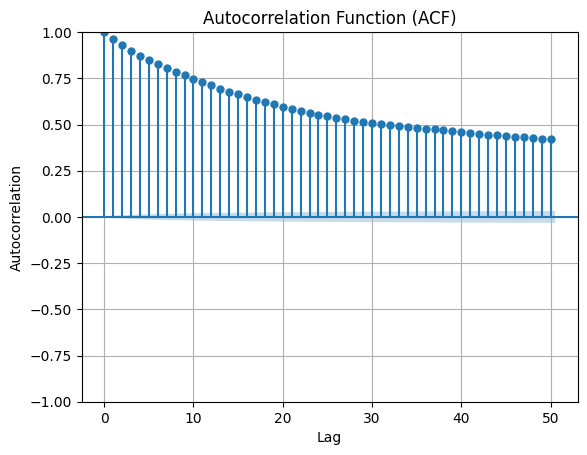

Autocorrelation: 0.960101247666363


In [ ]:
# Calculate autocorrelation function (ACF)
acf = pd.Series(data=df['redispatch']).autocorr()

# Plot autocorrelation function (ACF)
plt.figure(figsize=(10, 6))
plot_acf(df['redispatch'], lags=50, alpha=0.05)
plt.title('Autocorrelation Function (ACF)')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.grid(True)
plt.show()

print("Autocorrelation:", acf)